# Yield Modeling Tutorial
Dmitry Savransky (Cornell) and Rhonda Morgan (JPL)

Run the [SSW2024_YieldModelingTutorial1_Setup](https://colab.research.google.com/drive/1ubHBqz6Gcayzri9oMaVCbLvJJx_Nwk_B?usp=sharing) notebook to download the data. The setup notebook needs to just be run **once** once for Hands-on Session IV.

## Google Colab Usage
*Please read (don't just hit run) the information given above each code cell as there are separate install cells for Colab*
&#128992;
*and running Python on your computer*
&#128309;.

**Confirm login account**
* Please make sure to be logged in with the Google account you want to use for the exercises before running the code cells below. You can check by clicking the circular account icon in the top right corner of the colab notebook.

**Working directory**
* Note: The software and data will be installed in a directory called "SSW2024/SSWYieldModelingTutorial" in your Google drive. This directory will be created if it does not exist.

**Running cells**
* Run cells individually by clicking on the triangle on each cell

**To Restart runtime**
*   Click on Runtime menu item
*   Select Restart session
*   Select Run code cells individually from the top

**To Recreate runtime**
*   Click on Runtime menu item
*   Select Disconnect and Delete runtime
*   Select Run code cells individually from the top

**To Exit:**
*   Close the browser window

# How to Use This Tutorial

This notebook includes markdown cells (such as this one), which provide useful information and narration of what is happening, and code cells (such as the next one), which actually do things. To execute a code cell, click in the cell and then hit Shift+Enter. Alternatively, click within a cell and hit the Run button (play symbol). Depending on how you are running the notebook (via Google Colab or offline, and further depending on your installed version of Jupyter and/or Jupyter-lab), you may see slightly different options. The play symbol may appear in each cell, or above the cells in the toolbar.

When a cell completes executing, a number will appear (or update) on the left-hand side of the cell. You can also execute some or all of the cells via options in the 'Runtime' menu, above.  Again, depending on how you are running this notebook you may have either a 'Run' or 'Runtime' menu, but both will have similar options for executing chunks of the code.

**Important**: Note that some of the code blocks include exercises, with incomplete code, so you can't just run the whole notebook. You are strongly encouraged to go through the blocks one by one, in the order given.  Exercises do not need to be fully completed before proceeding to the next block.

## &#128992; Setup Google Drive directory

#### &#128992; **Run the next cell to mount the Google Drive**

In [ ]:
# You will be prompted to Permit this notebook to access your Google Drive files - Click on "Connect to Google Drive"
# You will then be prompted to Choose an account - click on your preferred Google account
# You will then confirm that Google Drive for desktop wants to access your Google Account - scroll to click "Allow"
# You may need to allow all permissions for this to work (click 'Allow All')
from google.colab import drive
drive.mount('/content/drive')

#### &#128992; **Run the next cell to define the ssw_dir**

In [ ]:
# This cell should *only* be executed if running the notebook in Google Colab
# SSW Yield Modeling Tutorial
YMT_dir = 'SSW2024/SSWYieldModelingTutorial' #@param {type:"string"}

#### &#128992; **Run the next cell to change to the YieldModelingTutorial directory and install the tutorial**

In [ ]:
# This cell should *only* be executed if running the notebook in Google Colab
# Create the YMT_dir directory in drive
import os

# Google top level drive dir
drive_dir = "/content/drive/MyDrive/"

# YMT_dir directory path
YMT_path = os.path.join(drive_dir, YMT_dir)

# Change to the YMT_path
os.chdir(YMT_path)

# Install the tutorial backend and requirements - this can also take a little while
!pip install -e .

## &#128992; Import jupyter widget for Colab

**Run the next cell**

In [ ]:
# need to import third party jupyter widget
from google.colab import output
output.enable_custom_widget_manager()

## &#128309; Change to the working directory for Python

**Run the next cell**

In [ ]:
# &#128309; Change to you the SSWYIeldModelingTutorial directory
# For example:  '/Users/jsmith/SSW2024/SSWYieldModelingTutorial'
import os
absolute_path_to_the_data_folder_on_your_machine = '' # Please complete!
os.chdir(absolute_path_to_the_data_folder_on_your_machine)

#  &#128992;  &#128309;  The rest of the notebook is for Colab or Python

# Tutorial Setup

In [1]:
# This is the start of the tutorial.  All users should execute all cells starting with this one
# import all required modules
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from sympy import symbols, cos, sin, Matrix, simplify, sqrt, solve
import matplotlib.pyplot as plt
import ipywidgets as widgets
import warnings
from matplotlib import ticker
import matplotlib.colors
import scipy
from SSWYieldModelingTutorial import SSWYieldModelingTutorial

In [2]:
# set up plotting
%matplotlib widget
plt.rcParams.update({'figure.max_open_warning': 0})

# Learning Outcomes

This tutorial is intended to introduce the key concepts in science yield modeling for exoplanet direct imaging missions. Upon completion of the tutorial you will be able to:

1. Compute the quantities measured by exoplanet imaging instrument
2. Estimate the probability of exoplanet detection by an imaging instrument
3. Evaluate the impacts of instrument and astrophysical noise sources on exoplanet imaging observations
4. Construct basic imaging campaign schedules
5. Evaluate the impacts of target availability and other constraints on exoplanet mission yield

# The Direct Imaging Observables

## Derivation of the Governing Equations
We wish to compute the direct imaging observable parameters over the course of a planet's orbit.  Typically, we parametrize these observables as the projected separation between star and planet ($s$) and the difference in brightness between planet and star (their flux ratio on a magnitude scale, which we call $\Delta\mathrm{mag}$.

A two-body (Keplerian) orbit is typically encoded via 6 variables: The semi-major axis ($a$) and eccentricity ($e$) which define the shape of the conic section of the orbit (in our case, all orbits will be elliptical or circular). The orbit's orientation in 3-dimensional space is encoded via three Euler angles: the argument of periapsis ($\omega$), the inclination ($I$), and the longitude of the ascending node ($\Omega$). Finally, in order to map time on the orbit to absolute time, we need to define the time of periapsis passage (closest approach between the planet and its host star: $t_p$). The planet's progress along its orbit can then be tracked via time, or any one of several anomaly angles, such as the true anomaly ($\nu$). From these parameters, we can define the planet's orbital radius magnitude as:
$$r = \frac{a(1 - e^2)}{1 + e\cos(\nu)}$$

![exoplanet orbit diagram with annotations](../img/exoplanet_orbit_diagram_annotated.png)

Let's get Python to produce equations for these starting from first principles.

In [3]:
# define required symbols and the rotation matrices for the orbit's rotation
r,I,O,w,nu,th = symbols("r,I,Omega,omega,nu,theta",real=True, positive=True)
rot1 = Matrix(([cos(O), sin(O), 0], [-sin(O), cos(O), 0], [0, 0, 1]))
rot2 = Matrix(([1, 0, 0], [0, cos(I), sin(I)], [0, -sin(I), cos(I)]))
rot3 = Matrix(([cos(w), sin(w), 0], [-sin(w), cos(w), 0], [0, 0, 1]))
pCi = rot3*rot2*rot1 # this is the rotation of the perifocal frame in the inertial frame
iCp = pCi.transpose() # this is the rotation of the inertial frame in the perifocal frame

# we can now define the orbital radius vector in the frame where the observer
# is located along the negative third axis
r_p = Matrix([r*cos(nu),r*sin(nu),0])
r_i = simplify(iCp*r_p)
r_i

Matrix([
[r*(-sin(Omega)*sin(nu + omega)*cos(I) + cos(Omega)*cos(nu + omega))],
[ r*(sin(Omega)*cos(nu + omega) + sin(nu + omega)*cos(I)*cos(Omega))],
[                                           r*sin(I)*sin(nu + omega)]])

We can simplify things a bit by defining the argument of latitude $\theta \triangleq \nu+\omega$:

In [4]:
r_i = r_i.subs(nu+w, th)
r_i

Matrix([
[r*(-sin(Omega)*sin(theta)*cos(I) + cos(Omega)*cos(theta))],
[ r*(sin(Omega)*cos(theta) + sin(theta)*cos(I)*cos(Omega))],
[                                      r*sin(I)*sin(theta)]])

We can now find an expression for the projected separation from the first two components of our orbital radius vector:

In [5]:
s = simplify(sqrt(r_i[0]**2 + r_i[1]**2))
s

r*sqrt(-sin(I)**2*sin(theta)**2 + 1)

The $\Delta\mathrm{mag}$ is a bit more complicated:
$$ \Delta{\textrm{mag}} \triangleq -2.5\log_{10}\left(\frac{F_P}{F_S}\right) =  -2.5\log_{10}\left(p\Phi(\beta) \left(\frac{R_P}{r}\right)^2 \right)$$
where $p$ is the geometric albedo of the planet (the fraction of light reflected/scattered by the planet), $R_P$ is the planet's radius, and $Phi(\beta)$ is the planet's phase function (how the fraction of reflected light changes with the planet's phase angle $\beta$).  The phase angle is the star-planet-observer angle, and can be approximated as:
$$ \cos\beta \approx \sin I \sin\theta$$

Note that we can calculate both $s$ and $\Delta\mathrm{mag}$ with only a subset of our orbital elements and planetary parameters.  All that we need is $a, e, \nu, \omega, I, R_P$.

Real planets can have very complex phase functions, based on many parameters whose distributions are not yet well known.  Instead of modeling all of this complexity, we frequently just use the Lambert phase function, which describes an isotropic scatterer (one that reflects light equally in all directions):

$$\pi\Phi_L(\beta) = \sin\beta + (\pi - \beta)\cos\beta$$

Let's now simulate the observable values over the course of one orbit. We'll define some parameters that are vaguely Earth-like:

In [6]:
# define the orbital elements. Note the use of astropy units to keep things consistent
a = 1*u.AU #semi-major axis = 1 AU
e = 0.2 # this is actually a pretty high eccentricity
I = 90*u.deg # 90 degree inclination - edge-on orbit
w = 15*u.deg # 15 degree argument of periapsis
R_P = 1*u.earthRad # Earth radius-equivalent planet
p = 0.367 # geometric albedo
nu = np.linspace(0,2*np.pi,100)*u.rad # The true anomaly varies between 0 and 2\pi over the course of the orbit

## Exercise 1
Now it's your turn.  Write code to use the variables defined in the previous block to compute the projected separation and $\Delta\mathrm{mag}$ over the course of the orbit.

In [ ]:
# compute the observables
# Note that these are numerical computations on arrays, so you should be using numpy
# methods, such as np.cos, np.sin, np.sqrt, etc.
r =       # compute the oribtal radius
theta =   # compute the argument of latitude
s =       # compute the projected separation
beta =    # compute the phase angle
Phi =     # compute the value of the Lambert phase function
dMag =    # compute the Delta mag

# if you get stuck, a reference solution is provided by:
# s, dMag = SSWYieldModelingTutorial.calc_s_dMag(a, e, I, w, R_P, p, nu)

Now that we have some values, let's plot them:

In [ ]:
# let's plot some values
fig1, ax1a = plt.subplots()

color1 = 'tab:red'
ax1a.set_xlabel(f'True Anomaly ({nu.unit})')
ax1a.set_ylabel(f'Projected Separation ({s.unit})', color=color1)
ax1a.plot(nu, s, color=color1)
ax1a.tick_params(axis='y', labelcolor=color1)
ax1a.set_xlim([0,2*np.pi])

ax1b = ax1a.twinx()
color2 = 'tab:blue'
ax1b.set_ylabel('$\Delta$mag', color=color2)
ax1b.plot(nu, dMag, color=color2)
ax1b.tick_params(axis='y', labelcolor=color2)

Remember: the point of computing these values is to check whether or not a planet is visible at a given time.  The simplest way to do so is to define limits on observable projected separations and $\Delta\mathrm{mag}$ values.  For projected separation, this actually maps quite well to how starlight-suppression systems work.  Essentially all such systems have an inner working angle (IWA) and outer working angle (OWA).  If expressed in units of arcseconds, these values map directly to minimum and maximum observable projected separations (in AU) when multiplied by the distance to the target (in parsecs).  For $\Delta\mathrm{mag}$, as we will presently see, setting limits is a bit more complicated, so for now, we will just say that we can pick a constant $\Delta\mathrm{mag}$ limit.

Let's define some limits and see how these limits interact with our plot:

In [ ]:
IWA = 0.075 #arcseconds
OWA = 2 #arcseconds
d = 10  #distane to star in parsecs
dMaglim = 25 #we have a constant limiting delta magnitude

## Exercise 2
Using the previously computed values of $s$ and $\Delta\mathrm{mag}$, along with the limits defined in the previous block, compute a boolean array of values (of the same size as `s` and `dMag`) that is True where the planet is observable and false otherwise:

In [ ]:
# You are being asked to compute boolean values on an array, which can be done
# with comparison operators such as >, >=, ==, etc.  Arrays of boolean values
# can also be ANDed or ORed as (bool arr 1) & (bool arr 2) and
# (bool arr 1) | (bool arr 2), respectively

observable_indices =

# if you get stuck, a reference solution is provided by:
# observable_indices = SSWYieldModelingTutorial.observable_indices(s, dMag, d, IWA, OWA, dMaglim)

In [ ]:
# let's update our plot with the observable regions highlighted
# the planet is obserable under our stated constraints (dashed lines)
# on the thicker portions of the plots

# this is just used to split the observable indices into contiguous blocks for plotting:
sepinds = SSWYieldModelingTutorial.split_observable_inds(observable_indices)

for inds in sepinds:
    ax1a.plot(nu[inds], s[inds],color=color1, linewidth=4)
ax1a.plot([0,2*np.pi], [IWA*d]*2, '--', color=color1)

for inds in sepinds:
    ax1b.plot(nu[inds], dMag[inds],color=color2, linewidth=4)
ax1b.plot([0,2*np.pi], [dMaglim]*2, '--', color=color2)

# scroll up to see the updates on your original plot

## The Impact of Orbital Inclination

Of all of the input parameters, the one that has the largest impact on these values is the inclination (why?).  Let's see how the curves change as we change the orbital inclination. Note that this is also a chance to check your results from the first two exercises.

interactive(children=(IntSlider(value=50, description='j'), Output()), _dom_classes=('widget-interact',))

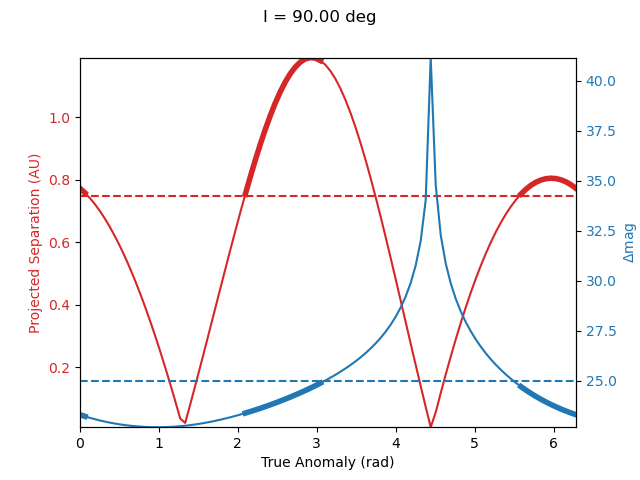

In [7]:
# We're going to now compute s and dMag on a grid of I and nu values
I0 = np.linspace(0,np.pi,101)*u.rad # full range of possible integrations
nu0 = np.linspace(0,2*np.pi,100)*u.rad # The true anomaly varies between 0 and 2\pi over the course of the orbit
[Is, nus] = np.meshgrid(I0,nu0)

ss, dMags = SSWYieldModelingTutorial.calc_s_dMag(1*u.AU, 0.2, Is, 15*u.deg,  1*u.earthRad, 0.367, nus)
ss = ss.transpose()
dMags = dMags.transpose()

# same constraints as before:
IWA = 0.075 #arcseconds
OWA = 2 #arcseconds
d = 10  #distane to star in parsecs
dMaglim = 25 #we have a constant limiting delta magnitude

fig2, ax2a = plt.subplots()

color1 = 'tab:red'
ax2a.set_xlabel(f'True Anomaly ({nu0.unit})')
ax2a.set_ylabel(f'Projected Separation ({ss.unit})', color=color1)
scurve = ax2a.plot(nu0, ss[0], color=color1)[0]
ax2a.tick_params(axis='y', labelcolor=color1)
ax2a.set_xlim([0,2*np.pi])
ax2a.plot([0,2*np.pi], [IWA*d]*2, '--', color=color1)

ax2b = ax2a.twinx()
color2 = 'tab:blue'
ax2b.set_ylabel('$\Delta$mag', color=color2)
dMagcurve = ax2b.plot(nu0, dMags[0], color=color2)[0]
ax2b.tick_params(axis='y', labelcolor=color2)
ax2b.plot([0,2*np.pi], [dMaglim]*2, '--', color=color2)

fig2.suptitle(f"I = {I0[0].to(u.deg) :.2f}")
overlines = []

def drawInclinationFrame(j):
    scurve.set_data(nu0, ss[j])
    dMagcurve.set_data(nu0, dMags[j])
    fig2.suptitle(f"I = {I0[j].to(u.deg):.2f}")
    ax2a.set_ylim([ss[j].value.min(), ss[j].value.max()])
    ax2b.set_ylim([dMags[j].min(), dMags[j].max()])
    obsinds = SSWYieldModelingTutorial.observable_indices(ss[j], dMags[j], d, IWA, OWA, dMaglim)
    sepinds = SSWYieldModelingTutorial.split_observable_inds(obsinds)
    while len(overlines) > 0:
        overlines.pop().remove()
    for inds in sepinds:
        overlines.append(ax2a.plot(nu0[inds], ss[j][inds],color=color1, linewidth=4)[0])
    for inds in sepinds:
        overlines.append(ax2b.plot(nu0[inds], dMags[j][inds],color=color2, linewidth=4)[0])

widgets.interact(drawInclinationFrame, j=widgets.IntSlider(min=0, max=len(I0)-1, step=1, value=50));
# use slider to change the orbit inclination

A key aspect of what we're seeing here is that orbital inclination places a limit on the range of observable face angle.  A face-on orbit (one with a 0$^\circ$ inclination) will always be viewed at a 90$^\circ$ phase (known as **quadrature**). Only an edge-on orbit (one with 90$^\circ$) inclination will actually pass through the full range of $\beta$ values (0 to 180$^\circ$).  For intermediate values of inclination, the planet phase will always be in the range $[90^\circ - I, 90^\circ + I]$.

Another very important thing to note is the range of projected separations.  If you look back to the orbital radius magnitude equation, you'll note that the orbital radius ranges between $a(1-e)$ and $a(1+e)$.  The projected separation will always be less than or equal to the orbital radius (we can see this by inspection of the equation we derived, above). This means that when the projected separation is smaller than the semi-major axis, this is due to either the orbital eccentricity or projection effects (e.g., when the orbit is anything other than face-on).  When the projected separation is greater than the semi-major axis, this is due *only* to eccentricity.  A cool result that you can prove from all of this is that, given a single observation of a planet, the observed projected separation is actually the maximum likelihood estimate of its semi-major axis.

# The Direct Imaging Observable Joint Probability Density Function

Now that we have the ability to compute the imaging observables, we can proceed to compute the joint probability density function of these values for a given population of planets. We will call this density function $f_{\Delta\mathrm{mag},s}$.

There are multiple different ways to do this calculation, but the conceptually simplest is via Monte Carlo: we will draw random samples from density functions describing all of our input parameters, and then use these to compute the corresponding projected separation and $\Delta\mathrm{mag}$ values.  We will then form a 2D histogram over these computed values, thereby estimating their joint probability density function.

An important thing to note is that, in reality, the input parameters may not be independent, and may have joint prior functions of their own.  Here, we will ignore this bit of complexity, and treat all inputs as fully independent of one another.

We are going to try modeling a population of Earth-like planets.  Note that there is an enormous body of literature establishing various priors for this population. Here, we will make multiple simplifying assumptions.

For the semi-major axis, we will assume a uniform distribution between 0.7 and 1.5 AU (note that this assumption is non-physical - real planet orbits appear to be distributed logarithmically in semi-major axis, but this is a reasonable approximation to make when focusing on a small interval of semi-major axes. We will similarly approximate eccentricities as uniformly distributed between 0 and 0.35 (again, this is not what the actual universe appears to do). We will take all of the planets in our population to have radii of exactly 1 Earth radius, and geometric albedos of 0.367.

Finally, we will assume that orbit orientation are isotropically distributed over the unit sphere (e.g., that there is no preferred orbital plane).  This means that both $\omega$ and $\Omega$ are uniformly distributed between 0 and $2\pi$ radians, whereas $I$ is sinusoidally distributed, e.g.:
$$f_\bar{I}(I) = \begin{cases} \dfrac{\sin(I)}{2}  & I \in [0, \pi] \\ 0 & \mathrm{else} \end{cases}$$

Finally, we are interested in sampling the populations consistently with arbitrarily timed observations.  Thus, we treat the time of observation as uniformly distributed, which corresponds to a uniform distribution in mean anomaly ($M$). This is related to the true anomaly via the Kepler time equation:
$$M = E - e\sin(E)$$
where $E$ is the eccentric anomaly, which maps to true anomaly as:
$$\tan\left(\frac{E}{2}\right) = \sqrt{\frac{1-e}{1+e}}\tan\left(\frac{\nu}{2}\right)$$

## Exercise 3
Let's generate some values and see how this all works:

In [ ]:
N = int(1e5); #number of samples to generate
# these values are constant
R_P = (1*u.earthRad).to(u.AU).value # Earth radius-equivalent planet in AU
p = 0.367 # geometric albedo

# we'll skip the units this time to make computations a bit more efficient
# Hint 1: numpy provides the very useful method np.random.uniform. See:
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html
#
# Hint 2: A sinusoidal distribution can be generated by taking the
#         arccosine of a uniform distribution between -1 and 1

# generate an array of semi-major axis values
# uniformly distributed between 0.7 and 1.5 AU:
avals =

# generate an array of eccentricity values
# uniformly distributed between 0 and 0.35
evals =

# generate an array of argument of periapsis values
# uniformly distributed between 0 and 2\pi
wvals =

# generate an array of inclination values
# sinusoidally distributed between 0 and \pi
Ivals =

# Generate an array of mean anomaly values
# uinformly distributed between 0 and 2\pi
Mvals =

# if you get stuck, a reference solution is provided by:
#avals, evals, wvals, Ivals, Mvals, R_P, p = SSWYieldModelingTutorial.gen_Earthlike_values(int(1e5))

Now that we have the values, we need a bit more work before we can compute our imaging observables.  In particular, note that the Kepler time equation is a transcendental function, and must be inverted numerically (typically using Newton-Raphson iteration). There are many, many software packages in the Python ecosystem that will do this for you - we will use our own implementation here, but lots of others are available to you.

Once we have the true anomaly values, we can use our previously written code to compute the corresponding projected separation and $\Delta\mathrm{mag}$ values.  We then use some helper method to compute the 2D histogram of these values (normalized by the number of samples and bin areas to make it representative of a true probability density function) and finally to plot the results.

In [ ]:
# compute true anomaly from mean anomaly and eccentricity
_,_,nuvals = SSWYieldModelingTutorial.invKepler(Mvals, evals, return_nu=True)


# set semi-major axis and eccentricity ranges:
arange, erange = [0.7, 1.5], [0, 0.35]

# compute the imaging observables
svals, dMagvals = SSWYieldModelingTutorial.calc_s_dMag(avals, evals, Ivals, wvals,  R_P, p, nuvals)

# generate the 2D histogram of the values
Cpdf, sax, dMagax = SSWYieldModelingTutorial.gen_Cpdf(1000, dMagvals, svals, arange, erange, p, R_P)

In [ ]:
fig3, ax3 = plt.subplots()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cs = ax3.contourf(
        sax,
        dMagax,
        Cpdf,
        locator=ticker.LogLocator(),
    )
ax3.set_xlabel("Projected Separation (AU)")
ax3.set_ylabel("$\Delta$mag");
cbar = fig3.colorbar(cs)
cbar.ax.set_title("$f_{\Delta\\mathrm{mag},s}$");

This plot looks a bit sparse, but its hard to tell.  Wouldn't it be great if we could compute the bounds of this density function?  Turns out that, while computing the distribution itself analytically is non-trivial (although possible), it is relatively straightforward to establish upper and lower bounds on $\Delta\mathrm{mag}$ as a function of $s$:

In [ ]:
dmagmax, dmagmin, dmag90 = SSWYieldModelingTutorial.calc_Cpdf_limits(sax, arange, erange, p, R_P)
ax3.plot(sax, dmagmax, "r", linewidth=4, label="$\\Delta\\mathrm{mag}_\\mathrm{max}$")
ax3.plot(sax, dmagmin, "b", linewidth=4, label="$\\Delta\\mathrm{mag}_\\mathrm{min}$")
ax3.plot(sax, dmag90, "k--", label="$\\beta = 90^\\circ$")
ax3.legend()
ax3.set_ylim([20,40]);
# check back to your original plot for the limits

## Fully Sampling the Joint Probability Density Function

Clearly, we are failing to completely fill the space with our sampling.  This is one of the drawbacks of any Monte Carlo approach, and is related to the so-called 'curse of dimensionality': the larger the number of dimensions in your system, the more samples you need to fully sample the phase space, quickly leading to an infeasible required number of samples.  On thing helps us in this particular case: if you look carefully, you'll note that the highest probability portion of the space lies along the minimum $\Delta\mathrm{mag}$ curve. This means that as we add more samples, we'll automatically fill in the most interesting (to us) part of the phase space first. However, the $10^5$ samples we generated here are clearly inadequate.  Typically, we will draw at least $10^8$ samples for this distribution.  This takes a while, so we've precalculated them for you (and actually gone a bit overboard and generated a full billion samples).  Here's what a better sampled version of this density function looks like (and this is a chance to check your work):

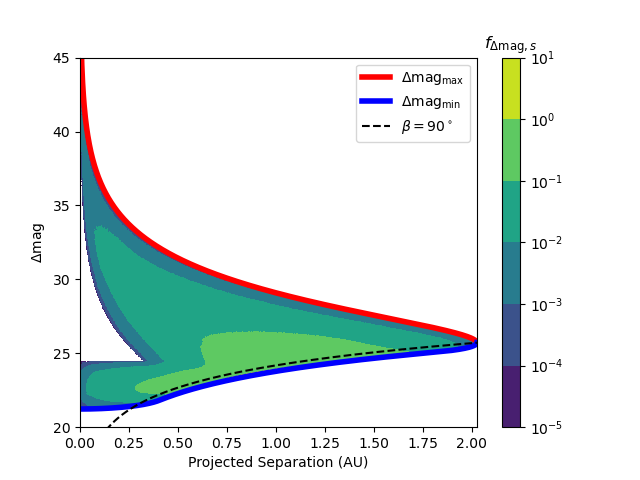

In [8]:
# set semi-major axis and eccentricity ranges:
arange, erange = [0.7, 1.5], [0, 0.35]
R_P = (1*u.earthRad).to(u.AU).value # Earth radius-equivalent planet in AU
p = 0.367 # geometric albedo
Cpdf, sax, dMagax = SSWYieldModelingTutorial.load_precomputed_completeness()
dmagmax, dmagmin, dmag90 = SSWYieldModelingTutorial.calc_Cpdf_limits(sax, arange, erange, p, R_P)
fig4, ax4 = plt.subplots()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cs = ax4.contourf(
        sax,
        dMagax,
        Cpdf,
        locator=ticker.LogLocator(),
    )
ax4.set_xlabel("Projected Separation (AU)")
ax4.set_ylabel("$\Delta$mag");
cbar = fig4.colorbar(cs)
cbar.ax.set_title("$f_{\Delta\\mathrm{mag},s}$");
ax4.plot(sax, dmagmax, "r", linewidth=4, label="$\\Delta\\mathrm{mag}_\\mathrm{max}$")
ax4.plot(sax, dmagmin, "b", linewidth=4, label="$\\Delta\\mathrm{mag}_\\mathrm{min}$")
ax4.plot(sax, dmag90, "k--", label="$\\beta = 90^\\circ$")
ax4.legend()
ax4.set_ylim([20,45]);

We immediately see that with a full $10^9$ samples, we fully fill the space between our maximum and minimum bounding lines.  More importantly, there are no samples outside of these lines, proving that the bounds are correctly computed. Take a moment to study this plot.  This is often referred to as a 'bird plot' (after the shape), and was first published by Bob Brown in his 2005 paper (possibly the most important contribution to the field of exoplanet yield modeling).  The shape of the joint density function is entirely driven by the input parameters.  The divot on the left-hand side of the plot is due to our inclusion of a maximum eccentricity value (allowing eccentricities up to the upper bound of 1 would fill in the blank area present in the current plot).  Finally, we can confirm what we suspected from our previous iteration of this plot: the highest probability region of this density function lies along the bounding minimum $\Delta\mathrm{mag}$ curve.

# Completeness

We now have all of the building blocks we need in order to compute **completeness**: the probability of detecting a planet from a given population about a given target star with a given instrument, assuming that one is there.  Obviously, this is a whole lot of 'givens', but we've actually already established all of them.  Our assumed population of planets is fully encoded in the joint probability density function we evaluated in the previous section.  The instrument is encoded by the inner and outer working angles and the limiting $\Delta\mathrm{mag}$. Putting these two together, the completeness is then just the marginalization of the joint density function under the instrumental constraints:
$$ c = \int_{s_\textrm{min}}^{s_\textrm{max}} \int_0^{\Delta\mathrm{mag}_\mathrm{lim}} f_{\Delta\mathrm{mag},s} \, \mathrm{d}\Delta\mathrm{mag}\,\mathrm{d}s$$
where $s_\textrm{min},s_\textrm{max}$ are the minimum and maximum observable projected separation values, which, as previously discussed can be computed as IWA$d$ and OWA$d$, respectively, where $d$ is the distance to the target star in parsecs.

As we have computed our joint observable distribution as a discretized, normalized 2D histogram, we can implement the double integral in the equation above as a double summation (this is equivalent to implementing a Riemann sum):
$$ c \approx \sum_{s = s_\textrm{min}}^{s_\textrm{max}} \sum_{\Delta\mathrm{mag} = 0}^{\Delta\mathrm{mag}_\mathrm{lim}} C_\mathrm{pdf}(s, \Delta\mathrm{mag})$$

Essentially, we are carving out a rectangular area within our joint density function (under the assumption that the limiting $\Delta\mathrm{mag}$ is constant at all projected separations), and then summing the contents of our histogram within this box.  This looks something like:

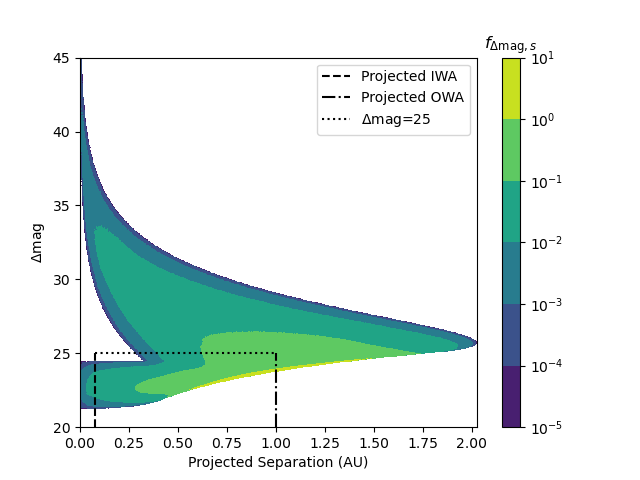

In [9]:
fig4, ax4 = plt.subplots()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cs = ax4.contourf(
        sax,
        dMagax,
        Cpdf,
        locator=ticker.LogLocator(),
    )
ax4.set_xlabel("Projected Separation (AU)")
ax4.set_ylabel("$\Delta$mag");
cbar = fig4.colorbar(cs)
cbar.ax.set_title("$f_{\Delta\\mathrm{mag},s}$");
ylim = [20,45]
ax4.set_ylim(ylim);
projIWA = 0.075 # AU
projOWA = 1 # AU
ax4.plot([projIWA] * 2, [ylim[0], 25], "k--", label="Projected IWA")
ax4.plot([projOWA] * 2, [ylim[0], 25], "k-.", label="Projected OWA")
ax4.plot([projIWA, projOWA], [25] * 2, "k:", label="$\\Delta$mag=25")
ax4.legend();

One caveat here is that the grid that we computed the histogram over may be discretized too coarsely (that is, we may wish to pick limits that fall between grid entries).  We solve this by interpolating over the grid.

## Exercise 4

Let's try this out.  Write a function that, given the joint observable PDF and instrument limits, computes the completeness.

In [ ]:
def calc_completeness(Cpdf, sax, dMagax, smin, smax, dMaglim):
    """Compute the completeness of an observation

    Args:
        Cpdf (np.ndarray):
            2D, normalized, joint probability histogram of s and dMag
        sax (np.ndarray):
            Projected separation axis of Cpdf (AU)
        dMagax (np.ndarray):
            dMag axis of Cpdf
        smin (arraylike):
            Minimum observable projected separation (projected IWA) (AU)
        smax (arraylike):
            Maximum observable projected separation (projected OWA) (AU)
        dMaglim (arraylike):
            Maximum observable Delta mag value

    Returns:
        arraylike:
            Completeness values

    Notes:
        All arraylike inputs must have the same dimensionalities (or be scalars)

    """


    # Your code goes here
    # Hint 1: You may find the method scipy.interpolate.RectBivariateSpline useful here. See:
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RectBivariateSpline.html
    #
    # Hint 2: The contents of Cpdf are probably transposed from what you might expect

    comp =

    return comp

# if you get stuck: a reference implementation is available in SSWYieldModelingTutorial.calc_completeness

# when you're done, test your function:
calc_completeness(Cpdf, sax, dMagax, 0.075, 1, 25)
# the expected output is ~0.42

## The Impact of Stellar Distance
Now that we have the capability to compute completeness values, we can explore how they change with inputs.  We've already established that the minimum and maximum observable projected separations are linear functions of stellar distance.  Let's look at how the target star's distance impacts the completeness:

interactive(children=(IntSlider(value=0, description='j', max=39), Output()), _dom_classes=('widget-interact',…

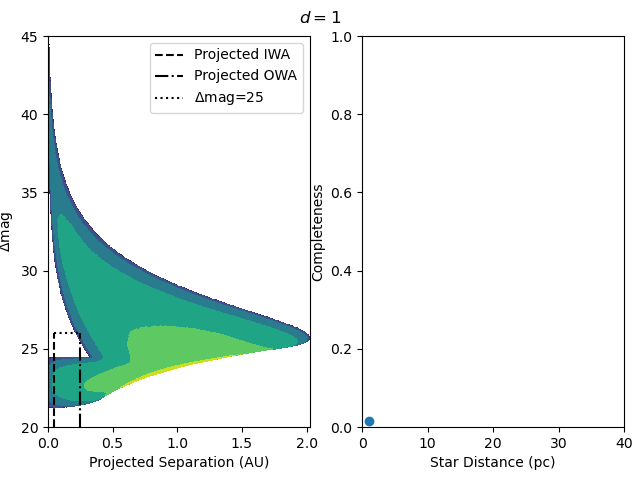

In [10]:
# We'll consider targets in the range of 1 to 41 parsecs
dists = np.arange(1, 41) # parsecs
IWA = 0.05 # arcseconds
OWA = 0.25 # arcseconds
smins = IWA*dists
smaxs = OWA*dists
dMaglim = 25
comps = SSWYieldModelingTutorial.calc_completeness(Cpdf, sax, dMagax, smins, smaxs, dMaglim)

ylim = [20,45]
fig5, axs5 = plt.subplots(1, 2)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cs = axs5[0].contourf(
        sax,
        dMagax,
        Cpdf,
        locator=ticker.LogLocator(),
    )
axs5[0].set_xlabel("Projected Separation (AU)")
axs5[0].set_ylabel("$\Delta$mag")
pIWA = axs5[0].plot([smins[0]] * 2, [ylim[0], dMaglim], "k--", label="Projected IWA")[0]
pOWA = axs5[0].plot([smaxs[0]] * 2, [ylim[0], dMaglim], "k-.", label="Projected OWA")[0]
dmaglim = axs5[0].plot(
    [smins[0], smaxs[0]], [25] * 2, "k:", label=f"$\\Delta$mag={dMaglim}"
)[0]
axs5[0].legend()
axs5[0].set_ylim(ylim)
xlim0 = axs5[0].get_xlim()
fig5.suptitle(f"$d = ${dists[0]}")

compline = axs5[1].plot(dists[0], comps[0])[0]
comppoint = axs5[1].scatter(dists[0], comps[0])
axs5[1].set_xlim([0, 40])
axs5[1].set_ylim([0, 1])
axs5[1].set_xlabel("Star Distance (pc)")
axs5[1].set_ylabel("Completeness")

plt.subplots_adjust(top=0.925, left=0.075, right=0.975)

def drawCompFrame(j):
    pIWA.set_data([smins[j]] * 2, [ylim[0], 26])
    pOWA.set_data([smaxs[j]] * 2, [ylim[0], 26])
    dmaglim.set_data([smins[j], smaxs[j]], [26] * 2)
    if smaxs[j] > sax.max():
        axs5[0].set_xlim([0, smaxs[j]])
    else:
        axs5[0].set_xlim(xlim0)
    fig5.suptitle(f"$d = ${dists[j]}")
    compline.set_data(dists[: j + 1], comps[: j + 1])
    comppoint.set_offsets((dists[j], comps[j]))

widgets.interact(drawCompFrame, j=widgets.IntSlider(min=0, max=len(dists)-1, step=1, value=0));
# use slider to change the star distance

We can see that the effect of moving to further and further targets: the observable box scales linearly outwards from the star, covering a different subsection of the joint density function for different stellar distances.  For the specific IWA/OWA values we have selected here, the bounding box covers the largest portion of the highest-probability portion of the distribution for a stellar distance of ~7 pc, leading to the highest completeness value at that distance.  

**Be very careful here**.  Note *all* of the assumptions that went into this result.  We had to both postulate the underlying planet population *and* the instrument's capabilities. Making changes to either would lead to a different result.

The second thing to note is that we only needed to compute the underlying density function once.  In order to get different completeness results for different observing cases, we only adjusted the limits of our integration (summation).  This will be a recurring theme as we study other effects.

## Habitable Zones and Stellar Luminosity

At first glance, our equations do not predict any changes in completeness with stellar luminosity, but this changes when you focus specifically on Earth-like planets.  While there is not broad consensus on what exactly makes a planet 'Earth-like', in general, you want these planets to receive about as much radiant flux from their host stars as the Earth receives from the sun. This means that we wish to match insolation distance rather than absolute distance between planet and star. That is, we want to scale our planets' semi-major axes as $a = \sqrt{L}a_{L=1 L_\odot}$ where $a_{L=1 L_\odot}$ is the semi-major axis at 1 solar luminosity. The full range of semi-major axes we wish to study is similarly scaled, leading to a very basic definition of the **habitable zone**.

This semi-major axis scaling implies that the orbital radius similarly scales as $r = \sqrt{L}r_{L=1 L_\odot}$, meaning that so does the projected separation: $$s = \sqrt{L}s_{L=1 L_\odot}$$

If you plug these scalings into the $\Delta\mathrm{mag}$ expression, you find:
$$\Delta\mathrm{mag} = \Delta\mathrm{mag}_{L=1 L_\odot} + 2.5\log_{10}\left(L\right)$$

Note that there's no need to recompute our underlying joint probability density function for different values of stellar luminosity.  Instead, we only need to re-interpret the axes.  With the inclusion of stellar luminosity, we read the abscissa as $s/\sqrt{L}$ and the ordinate as $\Delta\mathrm{mag} - 2.5\log_{10}\left(L\right)$.

## Exercise 5

Let's try this out. Update your previous completeness calculation function, taking into account the stellar luminosity (under the assumption that we're matching stellar insolation for our planet population).

In [ ]:
def calc_completeness(Cpdf, sax, dMagax, smin, smax, dMaglim, L):
    """Compute the completeness of an observation

    Args:
        Cpdf (np.ndarray):
            2D, normalized, joint probability histogram of s and dMag
        sax (np.ndarray):
            Projected separation axis of Cpdf (AU)
        dMagax (np.ndarray):
            dMag axis of Cpdf
        smin (arraylike):
            Minimum observable projected separation (projected IWA) (AU)
        smax (arraylike):
            Maximum observable projected separation (projected OWA) (AU)
        dMaglim (arraylike):
            Maximum observable Delta mag value
        L (arraylike):
            Stellar luminosity in solar luminosities

    Returns:
        arraylike:
            Completeness values

    Notes:
        All arraylike inputs must have the same dimensionalities (or be scalars)

    """


    # Your code goes here

    comp =

    return comp

# if you get stuck: a reference implementation is available in SSWYieldModelingTutorial.calc_completeness

# when you're done, test your function:
calc_completeness(Cpdf, sax, dMagax, 0.075, 1, 25, 1.5)
# the expected output is ~0.258

## The Impact of Stellar Luminosity

We can now explore how changing the luminosity impacts completeness:

interactive(children=(IntSlider(value=0, description='j', max=39), Output()), _dom_classes=('widget-interact',…

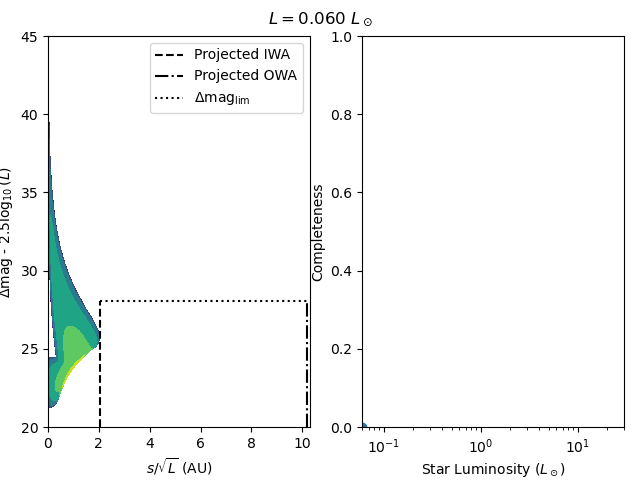

In [11]:
# assume a fixed star at 10 pc:
d = 10 # parsecs
IWA = 0.05 # arcseconds
OWA = 0.25 # arcseconds
smins = IWA*d
smaxs = OWA*d
dMaglim = 25

# generate a logarithmically spaced array of luminosities
Ls = np.logspace(np.log10(0.06), np.log10(30), 40)
comps2 = SSWYieldModelingTutorial.calc_completeness(Cpdf, sax, dMagax, smins, smaxs, dMaglim, Ls)

ylim = [20,45]
dmags2 = dMaglim - 2.5 * np.log10(Ls)
smins2 = smins/np.sqrt(Ls)
smaxs2 = smaxs/np.sqrt(Ls)
fig6, axs6 = plt.subplots(1, 2)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cs = axs6[0].contourf(
        sax,
        dMagax,
        Cpdf,
        locator=ticker.LogLocator(),
    )
axs6[0].set_xlabel("$s/\sqrt{L}$ (AU)")
axs6[0].set_ylabel("$\Delta$mag - 2.5$\log_{10}(L)$")
pIWA2 = axs6[0].plot([smins2[0]] * 2, [ylim[0], dmags2[0]], "k--", label="Projected IWA")[0]
pOWA2 = axs6[0].plot([smaxs2[0]] * 2, [ylim[0], dmags2[0]], "k-.", label="Projected OWA")[0]
dmaglim2 = axs6[0].plot(
    [smins2[0], smaxs2[0]], [dmags2[0]] * 2, "k:", label="$\\Delta$mag$_\\mathrm{lim}$"
)[0]
axs6[0].legend(loc=1)
axs6[0].set_ylim(ylim)
fig6.suptitle(f"$L = ${Ls[0] :.3f} $L_\odot$")

compline2 = axs6[1].semilogx(Ls[0], comps2[0])[0]
comppoint2 = axs6[1].scatter(Ls[0], comps2[0])
axs6[1].set_xlim([np.min(Ls), np.max(Ls)])
axs6[1].set_ylim([0, 1])
axs6[1].set_xlabel("Star Luminosity ($L_\odot$)")
axs6[1].set_ylabel("Completeness")

plt.subplots_adjust(top=0.925, left=0.075, right=0.975)


def drawCompFrame2(j):
    pIWA2.set_data([smins2[j]] * 2, [ylim[0], dmags2[j]])
    pOWA2.set_data([smaxs2[j]] * 2, [ylim[0], dmags2[j]])
    dmaglim2.set_data([smins2[j], smaxs2[j]], [dmags2[j]] * 2)
    if smaxs2[j] > sax.max():
        axs6[0].set_xlim([0, np.ceil(smaxs2[j]*10)/10])
    else:
        axs6[0].set_xlim([0,sax.max()])
    fig6.suptitle(f"$L = ${Ls[j] :.3f} $L_\odot$")
    compline2.set_data(Ls[: j + 1], comps2[: j + 1])
    comppoint2.set_offsets((Ls[j], comps2[j]))

widgets.interact(drawCompFrame2, j=widgets.IntSlider(min=0, max=len(Ls)-1, step=1, value=0));
# use slider to change the star luminosity

Note that the effect of scaling stellar luminosity is a bit more complex than when changing the stellar distance, as the luminosity changes the bounds of the box we're integrating within in both dimensions. For low stellar luminosities, the habitable zone moves inwards, towards the star, making the requirements on IWA very challenging.  For a fixed IWA, as we're assuming here, eventually the full joint distribution moves outside of the bounding box (at somewhere around 0.06 solar luminosities). For the assumed fixed distance of 10 pc (and our IWA/OWA/limiting $\Delta\mathrm{mag}$) assumptions), we find a peak in the completeness at around 0.65 solar luminosities.  As we continue to increase the luminosity, the habitable zone keeps moving outwards (which makes for easier IWA requirements) but the planets also get fainter (due to the reciprocal orbital radius magnitude term in the $\Delta\mathrm{mag}$ equation), making instrumental limiting $\Delta\mathrm{mag}$ requirements more challenging. By the time we get to 30 solar luminosities (roughly an A1V star - think just a bit dimmer than Vega), the bounding box has fully moved *below* the joint density function and the completeness is once again zero.

Finally, always remember that both the luminosity scaling and stellar distance scaling effects are happening at the same time!

# Integration Time

You may have noticed a glaring gap in our formulation of how we compute completeness: it appears to be entirely independent of integration (or exposure) time.  This is decidedly non-physical, as, intuitively, we should be able to see fainter planets if we collect more photons.  In reality, the integration time folds into the determination of our limiting $\Delta\mathrm{mag}$.  In order to see how, we first need to define an integration time model.

## Signal to Noise Ratio

We start by modeling the signal that we collect with our instrument as the sum of the photons from the thing we wish to measure (e.g., a planet, so we'll call this $c_p$) plus the photons from everything else (e.g., the background, so we'll call this $c_b$).  We can equivalently define the rates of photon arrival from each of these sources (which we'll represent with an overbar) such that our total measurement is:
$$z = \bar{c}_pt_\mathrm{int} +  \bar{c}_bt_\mathrm{int}$$

We ultimately wish to make a statistical statement about what we thought we detected, which is typically encoded as a **signal to noise** (SNR) metric (or ratio).  SNR actually has *a lot* of formal definitions, which vary by field and application area, but the one most useful in our case is the ratio of the expectation value of the signal (the thing we wish to measure) to the standard deviation of the noise (everything else).  Photon arrival is a Poisson process&mdash;that is, the distribution of photons collected in a given span of time is governed by a Poisson distribution, which describes the probability of recording a certain number of events per unit time when the events have a constant rate of occurrence. One nice attribute of a Poisson distribution is that its standard deviation is equal to the square root of its mean value.

So, under all these assumptions, our SNR metric is defined as:
$$\mathrm{SNR} = \frac{\bar{c}_pt_\mathrm{int}}{\sqrt{ \bar{c}_pt_\mathrm{int}  + \bar{c}_bt_\mathrm{int} }} = \frac{\bar{c}_p}{\sqrt{ \bar{c}_p  + \bar{c}_b }} \sqrt{t_\mathrm{int}}$$

Note that the denominator (the noise term) includes both the planet and background counts.  This is because Poisson noise (sometimes called **shot noise**) is generated by *all* incoming photons.  One immediate observation is that our SNR goes as the square root of integration time. So, if you want to double your SNR, you need to quadruple how long you collect photons for. The other thing to note is that this expression appears to predict that you can get to an arbitrarily high SNR if you are willing to integrate for an arbitrary long time.  This latter assertion is problematic because it is inherently non-physical for every optical system built to date.  In general, there will always be some **noise floor** (typically linked to the inherent stability of the optical system) that means that at a certain integration time, you stop gaining any SNR. Detailed modeling of such a noise floor can be arbitrarily complex, so instead, we will provide ourselves with a simplified model of the form:
$$\mathrm{SNR} = \frac{\bar{c}_pt_\mathrm{int}}{\sqrt{ \bar{c}_pt_\mathrm{int}  + \bar{c}_bt_\mathrm{int} + (Mt_\mathrm{int})^2) }}$$
where $M$ is a term inherently capturing our system's noise floor.  As $Mt_\mathrm{int}$ is added to our noise term in quadrature, $M$ can be interpreted as the photon rate associated with the standard deviation of a noise component that fundamentally cannot be subtracted out from our measured signal.

Using these definitions, we can now invert the expression to compute integration times as:
$$t_\mathrm{int} = \frac{ \bar{c}_p + \bar{c}_b }{\left(\dfrac{\bar{c}_p}{\mathrm{SNR}}\right)^2 - M^2}$$
which imposes the condition:
$$M < \frac{ \bar{c}_p}{\mathrm{SNR}}$$
These last two expressions fundamentally express the idea that for a given optical system and planet and noise count rates, there will be signal to noise ratios that are fundamentally unachievable (which matches our actual experience in real life).

## Exercise 6

Write a function to compute integration times given input values of $ \bar{c}_p, \bar{c}_b$, $M$ and the required SNR.

In [ ]:
def calc_intTime(C_p, C_b, M, SNR):
    """Find the integration time to reach a required SNR given the planet and
    background count rates as well as the optical system's noise floor.


    Args:
        C_p (arraylike Quantity):
            Planet count rate (1/time units)
        C_b (arraylike Quantity):
            Background count rate (1/time units)
        M (arraylike Quantity):
            Noise floor count rate (1/time units)
        SNR (float):
            Required signal to noise ratio

    Returns:
        ~astropy.units.Quantity(~numpy.ndarray(float)):
            Integration times

    .. note::

        All infeasible integration times should be returned as NaN values

    """

    # your code goes here:
    intTime =


    # infinite and negative values are set to NAN
    intTime[np.isinf(intTime) | (intTime.value < 0.0)] = np.nan

    return intTime

# if you get stuck: a reference implementation is available in SSWYieldModelingTutorial.calc_intTime

# when you're done, test your function:
C_p = 0.03/u.s # planet count rate photons/second (photons excluded from unit)
C_b = 0.01/u.s # background count rate photons/second (photons excluded from unit)
M = 0.003/u.s  # noise floor count rate photons/second (photons excluded from unit)
SNR = 5
calc_intTime(C_p, C_b, M, SNR)
# the expected output is ~1481.5 seconds

## Modeling Planet and Background Counts

Now that we have our SNR and integration time equations, we need to be able to model the individual terms involved, and map them to the quantities that determine completeness. We'll start with the planet count rate.

### Planet Count Rate
Remember that the $\Delta\mathrm{mag}$ encodes the flux ratio of the planet to its host star. Therefore, we can express the spectral flux density (or irradiance) of a planet as $C_\mathrm{star} 10^{-0.4\Delta\mathrm{mag}}$ where $C_\mathrm{star}$ is the spectral flux density of the star, and -0.4 is the reciprocal of -2.5. We can further define:
$$C_\mathrm{star} = \mathcal{F}_0 10^{-0.4\mathrm{mag}_\mathrm{star}}$$
where $\mathcal{F}_0$ is the spectral flux density (in your observing wavelength band) of a zero-magnitude star, and $\mathrm{mag}_\mathrm{star}$ is the apparent magnitude of your target star in that same band.

We've now defined the spectral flux density of the planet, but we actually care about the planet count rates recorded on our instrument's detector.  Recall that spectral flux density is energy per time per area per wavelength (thanks to the Planck constant, equivalently photons per time per area per wavelength). In order to compute the planet count rate, we need to scale the spectral flux density by our telescope's collecting area, the wavelength range of our observing band (the bandpass), and any losses due to the optical system.  So, we define:
$$\bar{c}_p =  \mathcal{F}_0 10^{-0.4(\mathrm{mag}_\mathrm{star}+ \Delta\mathrm{mag})}A \Delta\lambda \tau \tau_\mathrm{core} \mathrm{QE}$$
where $\Delta\lambda$ is the bandpass of our observing band, $\tau$ is the throughput of our system due to everything *other* than whatever technology is used to suppress the star's light (that is, all losses due to internal reflections and transmissions), and $\tau_\mathrm{core}$ is the throughput of our starlight suppression technology for point sources. $A$ is the effective collecting area of our telescope (e.g. the primary mirror area minus the area of any obscuration), which we compute (for a circular aperture of diameter $D$ and obscuration factor $f_\mathrm{obsc}$) as:
$$A = \pi \left(\frac{D}{2}\right)^2(1 - f_\mathrm{obsc})\,.$$
Finally QE is the quantum efficiency of our detector: this is the mean rate at which photons are converted to electrons (which is what ultimately gets measured and recorded). If you're keeping track of units, the application of the QE factor transforms any units of photons to units of electrons.  In real detectors, there's some additional complexity in the digitization of the electron counts to actual recorded counts (typically represented as digital numbers or DN units), but for simplicity we will assume that one electron produces on recorded count value.

To make things a bit cleaner, we can collect terms that will scale multiple of our count rates into a single parameter, 
$\eta \triangleq A \Delta\lambda \tau QE$, such that:
$$\bar{c}_p =  \mathcal{F}_0 10^{-0.4(\mathrm{mag}_\mathrm{star}+ \Delta\mathrm{mag})}\eta \tau_\mathrm{core}\,.$$

### Astrophysical Background Count Rates
The background signal will include counts from astrophysical sources as well as noise from the instrument itself.  The most important astrophysical background sources are the local zodiacal light ($\bar{c}_\mathrm{zodi}$; light reflected form the dust cloud shrouding the inner solar system), exozodiacal light ($\bar{c}_\mathrm{exozodi}$; light reflected from similar dust clouds in the target exosystem), and residual starlight not blocked by our starlight suppression technology ($\bar{c}_{sr}$). We model the local zodiacal light contribution as:
$$\bar{c}_\mathrm{zodi} = \mathcal{F}_0 10^{-0.4z} \Omega A \Delta\lambda \tau \tau_\mathrm{occ} \mathrm{QE} = \mathcal{F}_0 10^{-0.4z} \Omega\eta\tau_\mathrm{occ}$$
where $\tau_\mathrm{occ}$ is the throughput of our starlight suppression technology for infinitely extended sources, $z$ is the surface brightness of the local zodi in units of magnitudes per unit solid angle (nominally 23 mag arcsec$^{-2}$), and $\Omega$ is the solid angle of our photometric aperture. We will assume that our instrument is critically sampled at the central wavelength of our bandpass ($\lambda$) then we can compute the photometric aperture solid angle as:
$$\Omega = \pi\left(\frac{\lambda}{2D}\right)^2 \,.$$
Note that the unit of this value (if the wavelength and primary diameter have the same length unit) is a steradian (radian^2).  To make this work with the previous expression, we need to convert this to square arcseconds.

The exozodi contribution is computed in the exact same way, except that we replace the value of $z$ with whatever we are assuming for the brightness of the exozodi (at this point, we literally don't know what this should be - we haven't built instruments sensitive enough to directly measure this yet).

### Instrumental Background Count Rates

Another major source of background signal is due to the planet's host star.  While our starlight suppression technologies are designed to remove light from the star, they cannot do so perfectly, and so there will always be some amount of starlight that makes it into our science images.  We characterize this quantity via our instrument's contrast ($C$): the ratio of off-axis flux (at the location where we're making our measurement) to the peak of the star's flux in a measurement taken *without* the starlight suppression system in place. This value essentially encodes how efficiently we are able to block starlight.  Note that while this value is similar to the $\Delta\mathrm{mag}$, it is inherently an instrumental property whereas $\Delta\mathrm{mag}$ is an astrophysical one.  While many references may conflate the two, it is very important to understand the difference: $\Delta\mathrm{mag}$ is what the universe gives you, while $C$ is what your instrument is designed to do.  Given the instrument's contrast, we can compute the count rate due to the star's residual (unblocked) light as:
$$\bar{c}_{sr} =  C_\mathrm{star} C A \Delta\lambda \tau \tau_\mathrm{core} \mathrm{QE} = C_\mathrm{star} C\eta \tau_\mathrm{core} $$

Finally, we have background signal that is generated by the detector itself.  Modeling of detectors can get arbitrarily complicated, as there is a *lot* of very specific (and fascinating) physics in play here.  This is especially true when considering photon-counting detectors (literally devices that can, on average, track every individual photon intercepted).  Here, we will limit ourselves to two instrumental noise signals: dark current and read noise. Dark current is the signal generated by a detector when it is not illuminated, while read noise consists of excess electrons that are generated by the process of reading out the detector (that is, literally collecting all of the light accumulated in the detector and converting it to a digital signal).  Both of these are (on average) per-pixel effects, and so we need to know the relevant number of pixels we should be computing these for.  This requires us to define the number of pixels covered by our photometric aperture:
$$N_\mathrm{pix} = \frac{\Omega}{\theta_\mathrm{det}^2}$$
where $\theta_\mathrm{det}$ is the detector's pixel scale (the instantaneous field of view of each detector pixel).
The dark current count rate is then:
$$\bar{c}_\mathrm{dark} = N_\mathrm{pix} i_\mathrm{dark}$$
where $i_\mathrm{dark}$ is the dark current rate, measured in counts/second/pixel.

All of the preceding count rates have come from processes that are (or can be safely modeled as) continuous.  That is, for our astrophysical sources and starlight residual and dark current, we are accumulating photons (counts or digital numbers) throughout the length of an observation that have some average arrival rate, such that we can multiply these rates by the total integration time to get the expectation value for our recorded signal.  Read noise, however, is different as it represents a *discrete* process.  Counts due to read noise are only generated when we read out our detector.  We could do this once per observation, but that tends to be a bad idea because of the accumulation of cosmic rays, which tend to saturate our detector, as well as some other more finicky effects. So, in typical usage, we will read out our detector multiple times within the span of a single observation, and then sum the results.  To model this, we introduce the exposure time ($t_\mathrm{exp}$) parameter, which encodes the duration of each readout exposure.  The number of readouts is therefore given by $t_\mathrm{int}/t_\mathrm{exp}$. Because we have the integration time in the numerator, we can still compute a 'rate' for the contribution of the read noise, which will have the form:
$$\bar{c}_\mathrm{read} = N_\mathrm{pix} \frac{i_\mathrm{read}}{t_\mathrm{exp}}$$
where $i_\mathrm{read}$ is the read noise in units of electrons/pixel/readout.

## Modeling the Noise Floor

Perhaps the most difficult aspect of all of this to model is the noise floor ($M$). Conceptually, this term represents the part of the background signal that cannot be subtracted or otherwise removed from our measurements.  This implies that this term has to do with a variability in our optical system that we cannot model.  Formally, we can describe this as a variability in our instrument's **point spread function** (or impulse response).  The actual part of the background signal that will be most affected by such variability is the residual starlight that cannot be full suppressed.  We know, thanks to experience with high-performance, ground-based coronagraphs as well as space-based instrument on the Hubble and other observatories that we are able to subtract the contributions of some, but not all of this term, so we define a new variable, called the post-processing factor ($f_p$) such that:
$$M = \bar{c}_{sr} f_p \,.$$
The post-processing factor should be interpreted as the reciprocal of our expected ability to suppress residual starlight, such that $f_p = 0.1$ represents the assumption that our intrinsic noise floor lies at a factor of 10 below the residual starlight.

## Exercise 7

We now have all of the equations we need in order to implement a calculation of the planet, background, and noise floor count rates (the inputs to our previously written integration time calculation), so let's do just that.  First, a few implementation notes.  As you can see, there are a *lot* of inputs.  To make our lives a little easier, we will package these into three dictionaries: `static_params` (the values we expect to be more or less constant between different observations), `coronagraph` (values encoding the performance of the starlight suppression system) and `target` (values encoding the particulars of a given observation). Defining these dictionaries serves to prevent errors due to keeping track of the position of a lot of required inputs.

<div class="alert alert-block alert-danger">
<b>Warning</b> A key thing to keep in mind is that much of the modeling described in the previous section is greatly simplified, and omits a lot of finicky details that become important as you try to compute realistic integration times and count rates. Furthermore, many of the values (such as all of the coronagraph parameters and some of the detector parametrs) are not actually constants, but depend on other parameters such as wavelength, and the separation angles between the star and the planet. Our various simplifications are fine in the context of this tutorial, but be careful in trying to apply any of this in the real world.
</div>

You'll also note that there are a lot of units floating around these calculations.  We will again make use of `astropy`'s `Unit` class (https://docs.astropy.org/en/stable/units/) to help us, but these still have some limitations.  Most importantly, you cannot use an `astropy` `Quantity` object in an exponent, so we will omit the units on the zodi and exozodi brightness inputs.  Similarly, mathematical operations on quantities with units will work as expected, but may produce results with mixed units (for example nanometers divided by meters).  Every `Quantity` object has a useful built-in method called `decompose()` which will automatically resolve such mixtures to a single base unit.  Similarly, if you ever wish to extract the unit or value of a given quantity object `q`, you can call `q.unit` and `q.value`, respectively.

One more important note on units: there are cases where you divide two length units and expect the result to be an angle quantity (for example $\lambda/D$ is an angle such that if both inputs have the same length unit, the output is in radians).  The `Quantity` objects aren't quite smart enough to figure this out on their own, but allow you to specify those cases where dimensionless quantities should be interpreted as angles, via the `equivalencies` keyword input to the `to` conversion method.  For example:

In [ ]:
lam = 500*u.nm # wavelength
D = 6*u.m # diameter
lD = (lam/D).to(u.arcsec, equivalencies=u.dimensionless_angles()) # lambda/D in angle units
print(lD)

We will first define some representative input quantities for our count rate function:

In [ ]:
# define sample inputs to our count rate function
static_params = {"lam": 550*u.nm, # 550 nm central wavelength
                 "deltaLam": 110*u.nm, # 20% bandpass
                 "D": 6*u.m, # 6 meter telescope
                 "obsc": 0.1, # Primary is 10% obscured
                 "tau": 0.5, # The non-coronagraphic throughput
                 "QE": 0.9, # 90% Quantum Efficiency
                 # Zero-mag flux in photons cm^-2 nm^-1 s^-1 (photons omitted from unit):
                 "F0": 12000/u.cm**2/u.nm/u.s, # Zero-magnitude flux (approximate)
                 "pixelScale": 0.02*u.arcsec, # instantaneous field of view of each detector pixel
                 # dark current in counts/second/pixel (counts and pixels ommited from unit):
                 "darkCurrent": 0.0001/u.s,
                 "readNoise": 1e-6, # read noise in electrons/pixel/read
                 "texp": 100*u.s, # single exposure time
                 "ppFac": 0.1, # post-processing factor
                }

coronagraph = {"tau_core": 0.1, # point source throughput
               "tau_occ": 0.2,  # extended source throughput
               "contrast": 4e-11, # contrast (this represents a *very* good coronagraph)
              }

target = {"mag_star": 5, # apparent magnitude
          "zodi": 23, # local zodi (units omitted as we're using this as an exponent)
          "exozodi": 22, # exozodi (assume a bit brighter than local zodi)
         }

Now implement your function:

In [ ]:
def Cp_Cb_M(static_params, coronagraph, target, deltaMag):
    """Calculates electron count rates for planet signal, background noise,
    and noise floor for an observation.

    Args:
        static_params (dict):
            Dictionary of static parameters:
            lam (Quantity):
                Central wavelength of observing bandpass (length unit)
            deltaLam (Quantity):
                Bandpass (length unit)
            D (Quantity):
                Telescope aperture diameter (length unit)
            obsc (float):
                Fraction of the primary aperture that is obscured by secondary and
                secondary support structures
            tau (float):
                Optical system throughput excluding effects of starlight suppression
                system
            QE (float):
                Detector quantum efficiency
            F0 (Quantity):
                Spectral flux density of zero-magnitude star in observing band
                (1/length^2/length/time unit)
            pixelScale (Quantity):
                Instantaneous field of view of each detector pixel (angle unit)
            darkCurrent (Quantity):
                Dark current in counts/second/pixel (1/time unit)
            readNoise (float):
                Read noise in electrons/pixel/read
            texp (Quantity):
                Single readout exposure time (time unit)
            ppFac (float):
                Post-processing factor

        cornagraph (dict):
            Dictionary of coronagraph parameters for this observation:
            tau_core (float):
                Throughput of starlight suppression system for point sources
            tau_occ (float):
                Throughput of starlight suppression system for infinitely extended
                sources

        target (dict):
            Dictionary of target observing parameters:
            mag_star (float):
                Apparennt magnitude of target star in observing band
            zodi (Quantity)
                Surface brightness of local zodi in units of magnitude/arcsec^2.
                Input must have units of angle^{-2}.
            exozodi (Quantity)
                Surface brightness of exozodi in units of magnitude/arcsec^2.
                Input must have units of angle^{-2}.
        deltaMag (float):
                Assumed delta magnitude of planet in observing band


    Returns:
        tuple:
            C_p (~astropy.units.Quantity(~numpy.ndarray(float))):
                Planet signal electron count rate in units of 1/s
            C_b (~astropy.units.Quantity(~numpy.ndarray(float))):
                Background noise electron count rate in units of 1/s
            M (~astropy.units.Quantity(~numpy.ndarray(float))):
                Residual starlight spatial structure (systematic error)
                in units of 1/s
    """

    # Compute telescope collecting area:
    # this value should have units of length^2
    A =

    # compute the common factor of A*tau*deltaLam*QE
    # this value should have units of length^3
    eta =

    # Compute the count rates of the planet
    # this should have units of 1/time
    C_p =

    # Compute size of critically sampled photometric aperture
    # This should have units of angle^2
    # Hint: this is where that equivalencies input might be handy
    Omega = 

    # Compute the local and exozodi count rates
    # this should have units of 1/time
    C_zodi = 
    
    # Compute the local and exozodi count rates
    C_exozodi = 

    # Compute the count rates of the starlight residual
    # this should have units of 1/time
    C_sr = 

    # number of detector pixels in the photometric aperture = Omega / theta^2
    # this value should be unitless
    Npix = 

    # Compute the dark current count rate
    # this should have units of 1/time
    C_dc = 

    # Compute the read noise count rate
    # this should have units of 1/time
    C_rn =

    # total background signal rate
    # this should have units of 1/time
    C_b = C_sr + C_zodi + C_exozodi + C_dc + C_rn

    # compute the noise floor rate
    # this should have units of 1/time
    M = 

    return C_p, C_b, M



# if you get stuck: a reference implementation is available in SSWYieldModelingTutorial.Cp_Cb_M

In [ ]:
# Now test your function
C_p, C_b, M = Cp_Cb_M(static_params, coronagraph, target, 25)
# should be ~ 0.015/s, 0.025/s, 0.0006/s
intTime = calc_intTime(C_p, C_b, M, 5)
# should be ~ 4560 seconds or ~1.26 hours

Note that we now also have the ability to figure out the maximum achievable SNR for a given observation from our previously derived constraint: $$M < \frac{ \bar{c}_p}{\mathrm{SNR}} \quad \Longrightarrow \quad \mathrm{SNR} < \frac{ \bar{c}_p}{M}$$

In [ ]:
maxSNR = C_p/M
print(maxSNR) # will be 25

## Inverting the Integration Time

While the calculation of integration time given an assumed planet $\Delta\mathrm{mag}$ is important, it is not the end of the story. That's because we have set up our machinery to compute completeness as a function of limiting $\Delta\mathrm{mag}$.  That means that if we wish to calculate the completeness associated with a given integration time, we must be able to invert our integration time calculation to compute the equivalent maximum $\Delta\mathrm{mag}$ achievable for some integration time. This actually represents a key decision about how an exoplanet imaging survey is to be conducted. There are basically two options (with many possible minor variations):

1. Integrate on every target star to the same $\Delta\mathrm{mag}$ - that is, compute the integration time for each target using the same input $\Delta\mathrm{mag}$ value to the integration time equation.
2. Select integration times on every star to achieve different maximum $\Delta\mathrm{mag}$ and optimize the overall observing program to maximize the total accumulated completeness. 

The two approaches lead to different observing schedules and (likely) different mission outcomes.  While it may initially appear that the latter (optimization) approach is superior, it is important to understand that both methodologies have pros and cons.  The first approach produces a uniform survey and ensures that we can set a uniform bound on the existence of planets for all of the stars we observe. This makes it simpler to make statements about the actual population of planets that are out there once the survey is completed.  Such statements are also possible with the optimization approach, but require a lot more detailed modeling and careful treatment of the survey model that is used for population inference. On the other hand, integrating to a high $\Delta\mathrm{mag}$ value on a dim star is wasteful, and that time is likely better spent observing multiple brighter stars, or doing repeated observations on a previously discovered planet.  The completeness maximization approach makes such decisions automated and guarantees a maximized survey completeness (at least on paper).  However, you should never forget that all of the statements being made here are *statistical* in nature.  The maximum summed completeness produced by the numerical optimization represents an expectation value - it is the completeness we would achieve, on average, if we were able to run our experiment (the survey) many times over.  In reality, however, we only get to do the survey once, and it is impossible to detect fractional planets.  It would be a major bummer if we failed to discover a planet because our numerical optimization told us to integrate for a bit shorter on a given star, and the planet was just a bit dimmer than what our resulting observation could detect.  Conversely, the time we save on that integration could allow us to add another target to our list and therefore improve our odds of finding a planet elsewhere.  In short: this is very much an active area of research, and more remains to be said here. 

For now, let us see how we can invert the integration time equation to do such calculations.  Luckily for us, our expression from above is analytically invertible (which is not necessarily the case for all integration time models).  First, we invert the integration time expression via the quadratic equation:
$$t_\mathrm{int} = \frac{ \bar{c}_p + \bar{c}_b }{\left(\dfrac{\bar{c}_p}{\mathrm{SNR}}\right)^2 - M^2} \quad \Longrightarrow \quad \bar{c}_p = \frac{\mathrm{SNR} \left(\mathrm{SNR} + \sqrt{4 M^{2} t_\mathrm{int}^{2} + 4 \bar{c}_b t_\mathrm{int} + \mathrm{SNR}^{2}}\right)}{2 t_\mathrm{int}} \,.$$
Note that we use only the solution that yields a positive value (as negative count rates are non-physical).  We next solve our $\bar{c}_p$ model for $\Delta\mathrm{mag}$:
$$\bar{c}_p = \mathcal{F}_0 10^{-0.4(\mathrm{mag}_\mathrm{star}+ \Delta\mathrm{mag})}\eta\tau_\mathrm{core} \quad \Longrightarrow \quad   \Delta\mathrm{mag} = -\mathrm{mag}_\mathrm{star} -2.5\log_{10}\left(\frac{\bar{c}_p}{\mathcal{F}_0\eta\tau_\mathrm{core}}  \right) \,.$$

Substituting the former expression into the latter gives us a way of computing $\Delta\mathrm{mag}$ given an integration time (and therefore the completeness generated by a given integration time). Let's try it out.

## Exercise 8
Implement a method for computing the largest achievable $\Delta\mathrm{mag}$ for a given integration time.  We will use essentially the same inputs as we did for our previous method and will actually call it to compute $\bar{c}_b$ and $M$.  This is slightly wasteful, as it includes an unnecessary, redundant, calculation of $\bar{c}_p$, however, this is preferable to copy/pasting large amounts of code.

In [ ]:
def calc_dMag_from_intTime(static_params, coronagraph, target, SNR, intTime):
    """Find the achievable deltaMag for an observation for given SNR and integration
    time.

    Args:
        static_params (dict):
            Dictionary of static parameters. See Cp_Cb_M for details.

        cornagraph (dict):
            Dictionary of coronagraph parameters for this observation.
            See Cp_Cb_M for details.
        target (dict):
            Dictionary of target observing parameters. See Cp_Cb_M for details.
        SNR (float):
            Required signal to noise ratio
        intTime (Quantity):
            Integration time. Units of time.

    Returns:
        float:
            Achievable deltaMag

    """

    # Get values of C_b and M (first output is not needed)
    # Note that the deltaMag input here is entirely arbitrary, as we're not
    # using the C_p output.
    _, C_b, M = Cp_Cb_M(static_params, coronagraph, target, 0)

    # Compute C_p
    # This should have units of 1/time
    C_p = 

    # compute the common factor of A*tau*deltaLam*QE
    # this value should have units of length^3 
    # Hint: reuse your code from the last exercise
    eta = 

    # Compute the deltaMag corresponding to the inputs
    # This should be unitless
    deltaMag = 

    # return just the value
    return deltaMag.value

# if you get stuck: a reference implementation is available in SSWYieldModelingTutorial.calc_dMag_from_intTime

In [ ]:
# Now let's check our work.  We should be able to reproduce our dMag input
C_p, C_b, M = Cp_Cb_M(static_params, coronagraph, target, 26)
SNR = 5
intTime = calc_intTime(C_p, C_b, M, SNR)
dMag = calc_dMag_from_intTime(static_params, coronagraph, target, SNR, intTime)
# should be 26 

# Target List

We have now assembled the machinery necessary to compute integration times, achievable $\Delta\mathrm{mag}$ values, and completeness values for any arbitrary target.  What we're missing is some actual target data to work with. Let's fix that.  For our target list, we'll use the NASA ExEP Mission Star List for the Habitable Worlds Observatory, compiled by Eric Mamajek and Karl Stapelfeldt and described here: https://arxiv.org/pdf/2402.12414.  A description of the columns in the target list is available here: https://exoplanetarchive.ipac.caltech.edu/docs/API_mission_stars.html

We can load the target list via a utility method:

In [12]:
targets = SSWYieldModelingTutorial.load_HWO_MissionStars()
targets

,tic_id,hip_name,hip_compname,hd_name,hr_name,gj_name,constellation,hostname,sy_dist,sy_plx,...,wds_designation,wds_comp,wds_sep,wds_deltamag,eyes_lum,sy_disks_flag,sy_disks_flag_reflink,sy_planets_flag,sy_pnum,target_group
0,<a href=https://exoplanetarchive.ipac.caltech....,HIP 41926,NaN,HD 72673,HR 3384,GJ 309,NaN,HD 72673,12.1643,82.2080,...,NaN,NaN,NaN,NaN,NaN,N,NaN,N,0,C
1,<a href=https://exoplanetarchive.ipac.caltech....,HIP 42438,NaN,HD 72905,HR 3391,GJ 311,3 UMa,3 Ursae Majoris A,14.4388,69.2576,...,NaN,NaN,NaN,NaN,NaN,Y,<a href=https://ui.adsabs.harvard.edu/abs/2008...,N,0,B
2,<a href=https://exoplanetarchive.ipac.caltech....,HIP 42808,NaN,HD 74576,NaN,GJ 320,NaN,HD 74576,11.1917,89.3522,...,NaN,NaN,NaN,NaN,NaN,N,NaN,N,0,C
3,<a href=https://exoplanetarchive.ipac.caltech....,HIP 43587,A,HD 75732 A,HR 3522 A,GJ 324A,55 Cnc A,Copernicus,12.5868,79.4482,...,08526+2820,A,85.1,7.11,NaN,N,NaN,Y,5,C
4,<a href=https://exoplanetarchive.ipac.caltech....,HIP 43726,NaN,HD 76151,HR 3538,GJ 327,NaN,HD 76151,16.8465,59.3595,...,NaN,NaN,NaN,NaN,NaN,Y,<a href=https://ui.adsabs.harvard.edu/abs/2008...,N,0,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,<a href=https://exoplanetarchive.ipac.caltech....,HIP 38908,A,HD 65907 A,HR 3138 A,GJ 294A,NaN,HD 65907 A,16.1718,61.8360,...,07578-6018,A,60.6,4.47,NaN,N,NaN,N,0,B
160,<a href=https://exoplanetarchive.ipac.caltech....,HIP 40693,NaN,HD 69830,HR 3259,GJ 302,NaN,HD 69830,12.5794,79.4953,...,08184-1238,A,6.9,13.44,NaN,Y,<a href=https://ui.adsabs.harvard.edu/abs/2008...,Y,3,C
161,<a href=https://exoplanetarchive.ipac.caltech....,HIP 40843,NaN,HD 69897,HR 3262,GJ 303,chi Cnc,Chi Cancri,18.2233,54.8749,...,NaN,NaN,NaN,NaN,NaN,N,NaN,N,0,B
162,<a href=https://exoplanetarchive.ipac.caltech....,HIP 114948,NaN,HD 219482,HR 8843,GJ 1282,NaN,HD 219482,20.4426,48.9174,...,23170-6200,A,10.2,12.00,NaN,Y,<a href=https://ui.adsabs.harvard.edu/abs/2018...,N,0,C


Let's use our new tools to compute the completeness we get for each target if we always integrate to hit a $\Delta\mathrm{mag}$ of 25 (not e that this will not necessarily be possible for all targets for any given instrument design):

In [13]:
# get pre-computed completeness grid
Cpdf, sax, dMagax = SSWYieldModelingTutorial.load_precomputed_completeness()

# get target parameters
dist = targets['sy_dist'].values # distances in parsecs
lum = 10**targets['st_lum'].values # luminosities (original in log10(L_sun))

# IWA/OWA:
IWA = 0.075 #arcseconds
OWA = 2 #arcseconds
projIWA = IWA*dist
projOWA = OWA*dist

# compute completenesses
comps = SSWYieldModelingTutorial.calc_completeness(Cpdf, sax, dMagax, projIWA, projOWA, 25,lum)
print(comps.min(),comps.max(), comps.mean())

0.0003215735378814354 0.7749865252121114 0.205990773206564


As we can see, different targets can have wildly different completeness values. Let's try to visualize our target list coverage over the sky:

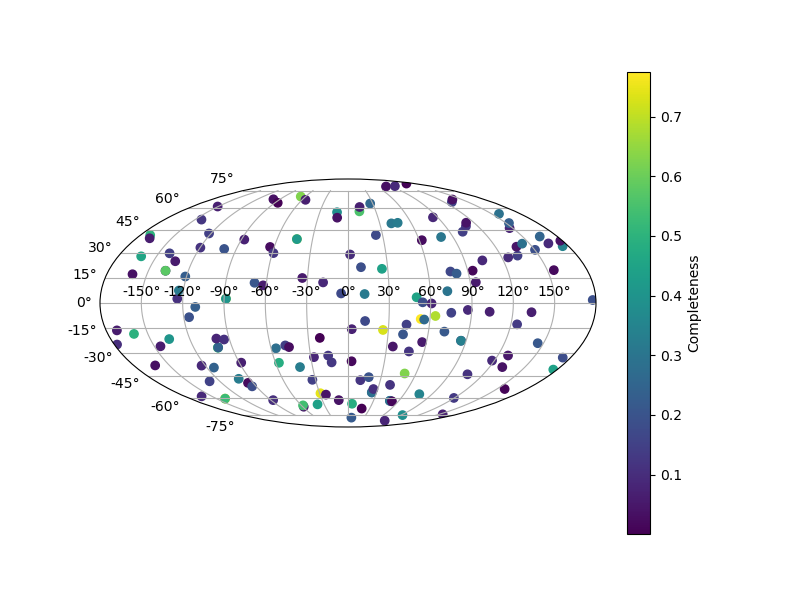

In [14]:
ra = targets['ra'].values*np.pi/180 # right ascension in radians
ra[ra > np.pi] -= 2*np.pi #wrap at 180 degrees
dec = targets['dec'].values*np.pi/180 # declinations in radians

fig7 = plt.figure(figsize=(8, 6))
ax7 = fig7.add_subplot(111, projection="mollweide")
p = ax7.scatter(ra, dec, c=comps)
ax7.grid(True)
plt.colorbar(p, label="Completeness");

Let's also check how long it would actually take to make all these observations:

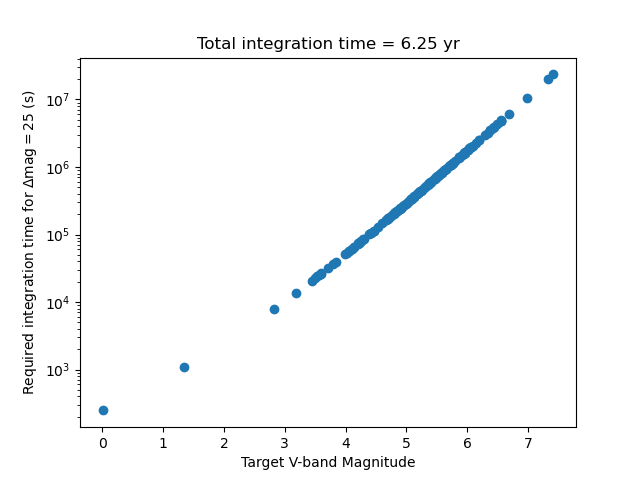

In [15]:
# we'll use a slightly more realistic coronagraph and observatory this time
static_params = {"lam": 550*u.nm, # 550 nm central wavelength
                 "deltaLam": 110*u.nm, # 20% bandpass
                 "D": 6*u.m, # 6 meter telescope
                 "obsc": 0.1, # Primary is 10% obscured
                 "tau": 0.1, # The non-coronagraphic throughput
                 "QE": 0.9, # 90% Quantum Efficiency
                 # Zero-mag flux in photons cm^-2 nm^-1 s^-1 (photons omitted from unit):
                 "F0": 12000/u.cm**2/u.nm/u.s, # Zero-magnitude flux (approximate)
                 "pixelScale": 0.002*u.arcsec, # instantaneous field of view of each detector pixel
                 # dark current in counts/second/pixel (counts and pixels ommited from unit):
                 "darkCurrent": 0.001/u.s,
                 "readNoise": 1e-6, # read noise in electrons/pixel/read
                 "texp": 100*u.s, # single exposure time
                 "ppFac": 0.1, # post-processing factor
                }

coronagraph = {"tau_core": 0.1, # point source throughput
               "tau_occ": 0.2,  # extended source throughput
               "contrast": 1e-10, # contrast (this represents a pretty good coronagraph)
              }

# but now we'll do all the targets at once
target = {"mag_star":  targets['sy_vmag'].values, # apparent magnitude
          "zodi": 23, # local zodi (units omitted as we're using this as an exponent)
          "exozodi": 22, # exozodi (assume a bit brighter than local zodi)
         }

C_p, C_b, M = SSWYieldModelingTutorial.Cp_Cb_M(static_params, coronagraph, target, 25)
intTimes = SSWYieldModelingTutorial.calc_intTime(C_p, C_b, M, 5)

fig8, ax8 = plt.subplots()
ax8.scatter(target["mag_star"], intTimes)
ax8.set_yscale("log")
ax8.set_xlabel('Target V-band Magnitude')
ax8.set_ylabel("Required integration time for $\Delta\mathrm{mag}=25$ (s)")
ax8.set_title(f"Total integration time = {intTimes.sum().to(u.yr) :.2f}");

Bottom line: depending on your assumptions about your optical system, it might take you over 6 years (longer than some mission concept total mission durations) to integrator on all of your targets just once!

# Mission Constraints

Finally, on top of everything else we've discussed, there exist mission constraints that dictate when and whether we can make observations of given target stars.  One mission constraint we've already touched upon: the total available time.  Missions are finite, especially those that make use of consumables such as fuel, or cryogens, or anything else that will eventually run out.  Worse yet, integration time for exoplanet observations is only a fraction of the overall mission time.  For each target, there will be some time needed to set up the observation (point at the target, wait for the observatory to equilibrate, dig a dark hole if using a coronagraph, etc.).  There will also be overhead time on each target (time needed to maintain the dark hole or observatory pointing, or to control a starshade, if using one).  All of this adds up quite rapidly.  Worse still: there will be silly people out there who want to use your observatory for science other than exoplanet imaging, and, of course, we have to share. So, even if you have a 5 year mission, you're going to have a lot less time (possibly less than half of that) to get your exoplanet science done.

## Keepout Maps
In addition to overall mission time constraints, there are specific constraints on when we can observe a given target. The whole point of exoplanet imaging is that we are creating an incredibly dark region in our focal plane in which we can try to collect the scant few photons exoplanets provide us.  If our observatory happens to be pointing in the vicinity of something bright (such as the Sun, or Earth, or even the moon), then that rather defeats the point.  Because of this, there will be so-called **keepout** regions - pointing geometries that are disallowed because they stray too near a bright foreground source. At the same time, depending on how the solar panels are mounted on our observatory, we may have disallowed pointing geometries because they would leave our solar panels unilluminated, meaning that there would not be enough power to run the observatory. Here is a schematic representation of the keepout regions for the sun, for an observatory placed on a Sun-Earth $L_2$ halo orbit (this is a large, periodic (in the rotating or synodic frame) orbit about the Sun-Earth 2nd Lagrange point, such that the sun, Earth, and moon, are always in the same general direction with respect to the observatory):

![keepout schematic](../img/keepout_diagram.png)

In the diagram, created by Gabriel Soto and published in Soto et al. 2019 (https://arc.aiaa.org/doi/10.2514/1.G003747), $\mathcal R$ represents the rotating frame, with $\mathbf{x}$ always pointing from the sun to the Earth (and to the second Lagrange point). The target star cannot lie anywhere within the shaded region to the left of $L_2$ because the sun would shine light into the telescope.  At the same time, a target star cannot lie anywhere within the shaded region to the right of $L_2$ because sunlight would reflect off of the starshade (if using one) and back into the telescope.  Alternatively, if our observatory has solar panels mounted parallel to the boresight (this is the case for the Nancy Grace Roman Space Telescope, for example), then solar panel illumination constraints would produce a keepout that looks a lot like that due to a starshade. 

We can capture all of this complexity in a **keepout map** - a boolean array where every row represents a target and every column represents some interval of mission time (say one day).  The value of each entry tells us whether the target can be observed on a given day.  Any proposed mission observation schedule must be consistent with the keepout map. 

Let's take a look at a keepout map for the HWO Mission Star list for a case where the keepout looks like the one in the diagram above. 

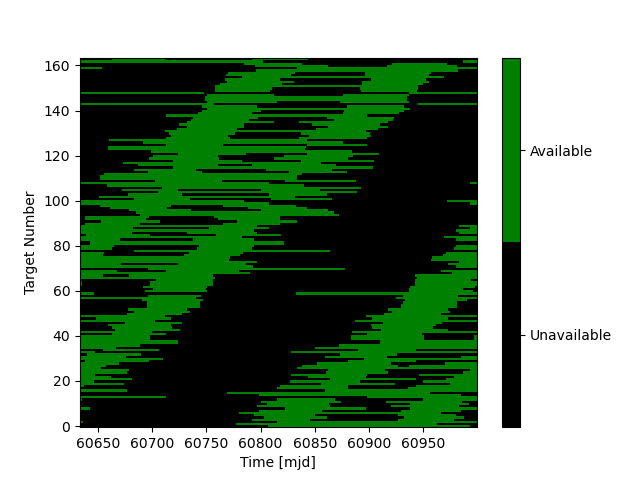

In [16]:
# load the keepout map
# koTimes will be an array of times corresponding to the columns of the keepout map
# koMap will have rows of target availability and columns of time:
# True values mean that a target can be observed and False means that it can't
# targNames will be an array of target names in the same order as the rows of koMap
# this should also be the order of the target list we loaded above
koTimes, koMap, targNames = SSWYieldModelingTutorial.load_HWO_MissionStars_koMap()

# plot the results
fig8, ax8 = plt.subplots(1, 1)
cmap = matplotlib.colors.ListedColormap(["black", "green"])
p = ax8.pcolor(
    koTimes.value,
    np.arange(len(targNames)),
    koMap,
    cmap=cmap,
)
ax8.set_ylabel("Target Number")
ax8.set_xlabel(f"Time [{koTimes.format}]")
cbar = plt.colorbar(p,ticks=[0.25, 0.75], drawedges=True)
cbar.ax.set_yticklabels(["Unavailable", "Available"]);

We can instantly see two things: first, many stars are unavailable for observation much of the time (bummer).  Second: there appears to be some structure to this map.  In fact, there is: the larger the (absolute value) of the ecliptic latitude of the target, the more often it will be observable. At the same time, the target's ecliptic longitude determines when during a calendar year the target will be observable. We can show this by sorting our targets prior to plotting:

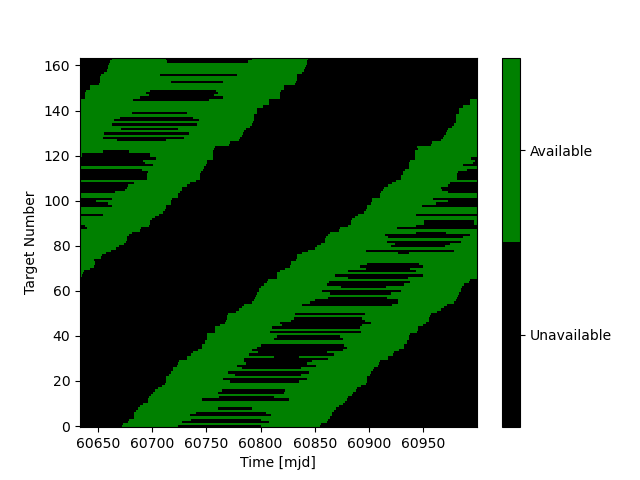

In [17]:
# calculate ecliptic target coordinates
coords =  SkyCoord(
            ra=targets["ra"].values * u.deg,
            dec=targets["dec"].values * u.deg,
            distance=targets['sy_dist'] * u.pc,
        ).heliocentrictrueecliptic

sInds = np.argsort(coords.lon)
fig9, ax9 = plt.subplots(1, 1)
cmap = matplotlib.colors.ListedColormap(["black", "green"])
p = ax9.pcolor(
    koTimes.value,
    np.arange(len(targNames)),
    koMap[sInds],
    cmap=cmap,
)
ax9.set_ylabel("Target Number")
ax9.set_xlabel(f"Time [{koTimes.format}]")
cbar = plt.colorbar(p,ticks=[0.25, 0.75], drawedges=True)
cbar.ax.set_yticklabels(["Unavailable", "Available"]);

Finally, let's plot the total amount of time each target is available throughout the course of one year:

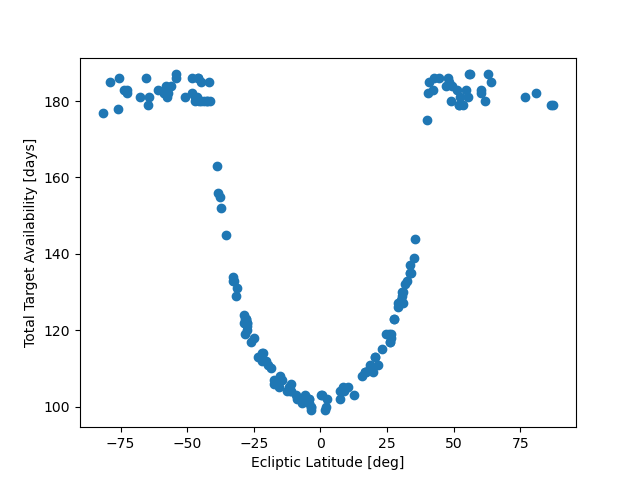

In [18]:
totavail = np.sum(koMap,
    axis=1,
)
plt.figure()
plt.scatter(coords.lat, totavail)
plt.xlabel("Ecliptic Latitude [deg]")
plt.ylabel("Total Target Availability [days]");

So, for this particular observatory design, targets are available no more than approximately 50% of the time (and, for targets near the ecliptic, for as little as about 100 days out of every year).

## Exercise 9

Let's get some practice using the keepout map.  Write a function that takes a proposed observation of one or more of our target stars (encoded as a start time and observation duration) and evaluates whether a target is available during this time.  Note that as our keepout map is discretized in one day intervals, we will be approximating the target availability somewhat. We will assume that the target is available for observation if it is listed as available (True) in the koMap array for *all* days when an observation is taking place, and no available otherwise.  There are many ways of extracting the indices of the koMap when an observation is taking place, but you may find the method `np.searchsorted` (https://numpy.org/doc/stable/reference/generated/numpy.searchsorted.html) useful here. 

In [ ]:
def check_target_availbility(koTimes, koMap, targetInds, obsStart, obsDurations):
    """Check whether targets are available (out of keepout) for proposed observations

    Args:
        koTimes (~astropy.time.Time):
            Absolute MJD mission times from start to end in steps of 1 d
        koMap (~numpy.ndarray(bool)):
            True means a target unobstructed and observable, and False means a
            target unobservable due to obstructions in the keepout zone.
        targetInds (arraylike):
            Indices of targets to check
        obsStart (~astropy.time.Time):
            Observation start time (absolute time)
        obsDurations (Quantity):
            Duration of observation(s). Time units.


    Returns:
        ~numpy.ndarray(bool):
            Boolean array of target availability. True means the target is available
            for observation and false means it is not. The size of this array should be
            the same as the size of targetInds.

    .. note::

        The size of targetInds and obsDurations must be the same.

    """

    # calculate observation end times:
    obsEnds = 

    # find index  of start time in koTimes
    startInd = 

    # find indices of end times in koTimes
    endInds = 

    # compute availability
    # for target j, koMap must be true for *all* indices between 
    # startInd and endInds[j] for the target to be available
    avail = 

    return avail

# if you get stuck: a reference implementation is available in SSWYieldModelingTutorial.check_target_availbility

In [ ]:
# now let's check our implementation
# let's look at three different targets:
targetInds = [0, 55, 150]
# all observations start at the same time:
obsStart = Time(60809.0, format="mjd", scale="tai")
# but have different durations:
obsDurations = np.array([1, 30, 100])*u.hr
avail = check_target_availbility(koTimes, koMap, targetInds, obsStart, obsDurations)
# should be True, False, False
# The first target is available on the day the observation takes place
# The second target is unavailable on both days of the observation
# The third target is initially available (first three days) but then becomes unavailable (last 2 days)

# Concluding Remarks

In this tutorial, we have been introduced to some of the core building blocks of estimating yield for an exoplanet direct imaging mission.  Here, we will briefly discuss how these blocks are put together.  We start with a description of our mission, including an instrument and observatory design, an input target list, and a statement of mission constraints (nominally the total mission time, the fraction of that time available for exoplanet science, and the parameters that allow us to evaluate a keepout map for our target list). We must then generate a mission schedule, consisting of a list of observing times and durations (that is, when we wish to integrate on a given target, and for how long). This schedule must fully conform to our mission constraints (e.g. no looking at stars when they're in keepout, and no exceeding your time allocation).

For each observation, we can then compute the maximum achievable planet $\Delta\mathrm{mag}$ and from this, the completeness of the observation for a planet population of interest. We sum all of these completeness values together to get the total mission completeness.  This value, in turn, is multiplied by the assumed occurrence rate of planets (frequently called $\eta$, or $\eta_\oplus$ for Earth-like planets specifically). This value:
$$\eta \sum_i c_i $$
where $c_i$ are the completeness values of each observation in our mission schedule, is the expected detection yield of our mission.